# ITEM DEMAND FORECASTING

In [8]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Importing Libraries and Data

In [9]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)

# Exploratory data analysis

In [10]:
df['date'].min(), df['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

As we can see that the data starts from the 1st month of 2013. It goes untill the 31st of the third month of 2018

In [12]:
train.shape, train.dtypes

((913000, 4),
 date     datetime64[ns]
 store             int64
 item              int64
 sales             int64
 dtype: object)

In [13]:
test.shape, train.dtypes

((45000, 4),
 date     datetime64[ns]
 store             int64
 item              int64
 sales             int64
 dtype: object)

In [14]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [16]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [17]:
test.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

In [18]:
df.head(), df.tail()

(        date  store  item  sales  id
 0 2013-01-01      1     1   13.0 NaN
 1 2013-01-02      1     1   11.0 NaN
 2 2013-01-03      1     1   14.0 NaN
 3 2013-01-04      1     1   13.0 NaN
 4 2013-01-05      1     1   10.0 NaN,
             date  store  item  sales       id
 44995 2018-03-27     10    50    NaN  44995.0
 44996 2018-03-28     10    50    NaN  44996.0
 44997 2018-03-29     10    50    NaN  44997.0
 44998 2018-03-30     10    50    NaN  44998.0
 44999 2018-03-31     10    50    NaN  44999.0)

On January 1, 2013, 13 items of item 1 were sold in the 1st store. On another date, there was no sale of the item 50 in the store no. 10.

In [19]:
# How is sales distribution?
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [20]:
# How many stores are there?
df[["store"]].nunique()

store    10
dtype: int64

In [21]:
# How many items are there?
df[["item"]].nunique()

item    50
dtype: int64

In [22]:
# How many unique items are in each store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [23]:
# Are there equal numbers of sales in each store?
df.groupby(["store"]).agg({"sales": ["sum"]})

,sales
,sum
store,
1,4315603.0
2,6120128.0
3,5435144.0
4,5012639.0
5,3631016.0
6,3627670.0
7,3320009.0
8,5856169.0


In [24]:
# Sales statistics in store-item breakdown
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

# Feature Engineering

# Data Features

In [25]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


Now that we have the month information, we can advance the descriptive analysis.

In [26]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

At the moment, I have access to information about how much is sold in which store, from which item, in which month.

# Random Noise

We add random values that are as large as the size of the dataframe to the new features we will create.
Adding noise here prevents overfitting. It increases our prediction performance.

In [27]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted features

We will be producing features related to the sales numbers of the past period.
Lag means delay. Shifted is also used in the same sense.

The time period t was most affected by t-1, sequentially from t-2.
So we assume that the next day's sale of a store is affected by the previous day's sale, so we will need to derive features for that.
These features will also create the values of the sales variable in previous periods.
To do this, the data must be ordered according to store, item and date so that we can produce these features correctly.

In [28]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [29]:
df.groupby(["store", "item"])['sales'].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

Let's apply a delay of 1 to the whole dataset. So we calculated 1 lag of each value.

In [30]:
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

Let's write a function for this. We will give the Dataframe to this function, we will set the delays we want. It will travel in delays. It will calculate the 30-day, 60-day, 90-day delay and add it to the dataframe as a new variable in order. It will add that into the dataframe, adding noise to it.

In [31]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

Our main goal is to catch the trend, seasonality and level.
Since this is a 3-month period, we have added it here as multiples of 3 months, 3 months +1 week, 3 months + 2 weeks, 6 months, etc.

In [32]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rolling Mean Features

This is the moving average. If I'm going to make predictions in a 3-month period, I need to show the patterns 3 months before that to my model.

In [33]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [34]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [35]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.418728,51.608744,66.400265,66.124118,69.032223,79.985031,78.849950,60.444539,100.031379,74.973364,88.307471,83.929306
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,66.975887,50.004769,67.179399,58.104227,76.585670,81.082144,79.930353,75.006014,77.152926,69.779428,88.968458,84.683313
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.264621,63.500924,71.821578,64.882730,71.668816,87.646103,81.040217,66.961735,98.990651,73.031469,87.360518,87.307782
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,73.166886,76.055909,70.650046,71.107621,66.326891,82.498610,90.530879,70.206722,80.064619,81.238796,86.964637,86.248882
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,58.504463,71.067310,52.702297,67.578136,48.214888,77.847857,102.782670,99.669187,97.942182,81.898424,91.000534,86.012847


# Exponentially weighted mean features

Here, as an example, I put a rolling mean and a weighted average with alpha values of 0.99, 0.95, 0.7 and 0.1.

The weighted average would give more weight to the closest values when the Alpha was 0.99, and would give more weight to the farthest values when it was 0.1.

In [37]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm01": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm01
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


When we take the exponential average of the 2 lags of 14, when we say give 0.99 weight to 11, 11.019802 is found. It's getting closer to 13 for 0.1. In fact, while the average of these two with the moving average is 12, when we say give weight to this first with alpha, the average changes.

Let's give lags and alphas as a combination to accommodate the influence of past periods.
When we use lightgbm later, we will be waiting to see if features are produced against combinations such as Lag 91 & Alpha 0.95 or Lag 98 & Alpha 0.7 and which ones will be more meaningful.

In [39]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.418728,51.608744,66.400265,66.124118,69.032223,79.985031,78.849950,60.444539,100.031379,74.973364,88.307471,83.929306,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,66.975887,50.004769,67.179399,58.104227,76.585670,81.082144,79.930353,75.006014,77.152926,69.779428,88.968458,84.683313,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.264621,63.500924,71.821578,64.882730,71.668816,87.646103,81.040217,66.961735,98.990651,73.031469,87.360518,87.307782,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,73.166886,76.055909,70.650046,71.107621,66.326891,82.498610,90.530879,70.206722,80.064619,81.238796,86.964637,86.248882,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.602440,83.485707,80.000156,66.038719,66.956088,70.379233,65.541

In [40]:
df.shape

(958000, 71)

As we can see in the beginning we had four features now we have 71

# One-hot Encoding

In [41]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
df.shape

(958000, 146)

The number of variables increased from 71 to 146.

# Converting sales to log(1+sales)

In [42]:
df['sales'] = np.log1p(df["sales"].values)
df.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Modelling

Submissions are evaluated in this competition on SMAPE (Symmetric mean absolute percentage error (adjusted MAPE)) so we will define a function in order to evaluate the difference between forecasts and actual values.
When we use SMAPE it allows us to evaluate an error as a percentage

In [43]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In summary, our cost functioncompares the estimated values with the actual values. It then takes their absolute values and converts them to percentage form.

In [44]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

We also define a lgbm_smape function to optimize the lightgbm function accordingly. We need to translate this custom cost function into the language that lightgbm understands. We have done a logarithmic transformation before. We will have the opportunity to apply this to the smape function, which will also undo this logarithmic transformation.

# Time-Based Validation Sets

The problem asks us to predict the first 3 months of 2018 in the test set. The train set is between January 2013 and December 2017.

I need to do something like that, I have to create 2 sets within the set given to me as a train set.
One must be train and the other must be validation.
When we randomly divide the train and validation sets, our date context will be broken, so we need to manually separate the train and validation sets, not randomly.

Let's create our train set until the beginning of 2017, and let's take the first 3 months of 2017 as a validation set.

In [45]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

# LightGBM Model

In [46]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315264 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.172569	training's SMAPE: 17.5986	valid_1's l1: 0.170935	valid_1's SMAPE: 17.4715
[200]	training's l1: 0.1423	training's SMAPE: 14.5739	valid_1's l1: 0.145246	valid_1's SMAPE: 14.8999
[300]	training's l1: 0.136707	training's SMAPE: 14.014	valid_1's l1: 0.140535	valid_1's SMAPE: 14.4274
[400]	training's l1: 0.134536	training's SMAPE: 13.7978	valid_1's l1: 0.138893	valid_1's SMAPE: 14.263
[500]	training's l1: 0.133207	training's SMAPE: 13.6653	valid_1's l1: 0.137662	valid_1's SMAPE: 14.1394
[600]	training's l1: 0.132262	training's SMAPE: 13.571	valid_1's l1: 0.136641	valid_1's SMAPE: 14.0368
[700]	training's l1: 0.13156	training's SMAPE: 13.5008	valid_1's l1: 0.135886	valid_1's SMAPE: 13.9607
[800]	training's l1: 0.130983	training's SMAPE: 13.

In the 1000th iteration, the smallest value is reached. Our error is 13,8248 %.

For example, if I said that an item in 1 store will sell 100 units in the future 3-month period, it may be 113,8248 units, it may be 86,1752 units, so I have a 13,8248 % margin of error.
We made a guess, but we haven't set up the final model where the best iteration is set yet.

# Feature Importance

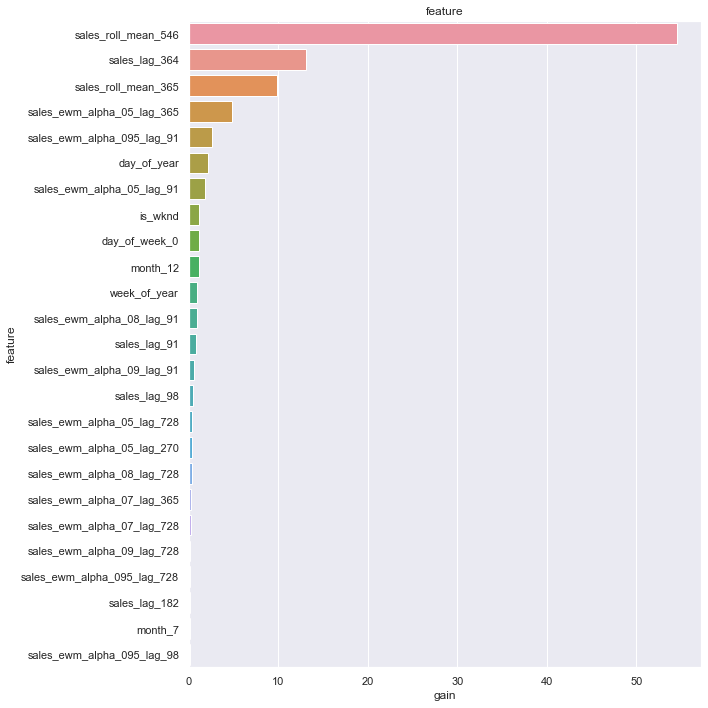

In [48]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30, plot=True)

plt.show()

Our newly derived features are at the top of the ranking.

# Final Model

When we focus on NaN values of 'sales' in the dataframe, we know that this will correspond to the test set.
We brought together 2 dataframes, in which the train set with sales parts and the test set without.

In [98]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": 600}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.358907 seconds.
You can set `force_col_wise=true` to remove the overhead.


# Submission

In [99]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,sales
0,0,12.710799
1,1,13.760560
2,2,14.829172
3,3,15.491082
4,4,16.513490
